### <h3> Prova 3 de LTC - Questão 3

In [68]:
import numpy as np
import sympy as sp
import control as ct
import matplotlib.pyplot as plt

##### <h5> A metodologia para o projeto é apresentado a seguir

##### <h5> Sistema

In [69]:
s = ct.tf('s')
num_G = [15.25]
den_G = [10, 1]
G = ct.tf(num_G, den_G)
n = len(den_G)-1
G

TransferFunction(array([15.25]), array([10,  1]))

##### <h5> Polos e zeros da malha aberta

In [70]:
print("Polos: ", ct.poles(G))
print("Zeros: ", ct.zeros(G))

Polos:  [-0.1+0.j]
Zeros:  []


##### <h5> Especificações de projeto

In [71]:
ts = 10
tau = ts/4

##### <h5> Polos de malha fechada desejados

In [72]:
p1 = -1/tau
p2 = -4
p = [p1, p2]

for i in range(len(p)):
    print(p[i])

-0.4
-4


##### <h5> Passagem da função de transferência de malha aberta para espaço de estados

In [73]:
ultima_linha = np.zeros((1, n))
aux = (den_G[::-1])[:-1]

for i in range(len(aux)):
    ultima_linha[0][i] = -aux[i]

A = np.block([[np.zeros((n-1, 1)), np.eye(n-1)],
              [ultima_linha]])

B = np.block([[np.zeros((n-1, 1))],
              [1]])

C = np.zeros((1, n))
for i in range(len(aux)):
    C[0][i] = num_G[::-1][i]

D = np.block([[0]])

print("A: ")
print(A)
print("B: ")
print(B)
print("C: ")
print(C)
print("D: ")
print(D)

A: 
[[-1.]]
B: 
[[1.]]
C: 
[[15.25]]
D: 
[[0]]


##### <h5> Criação do Espaço de Estado aumentado

In [74]:
Aa = np.block([[A, np.zeros((n,1))],
               [-C, 0]])

Ba = np.block([[B],
               [0]])

print("Aa:")
print(Aa)
print("Ba:")
print(Ba)

Aa:
[[ -1.     0.  ]
 [-15.25   0.  ]]
Ba:
[[1.]
 [0.]]


##### <h5> Cálculo do ganho aumentado

In [75]:
F = np.array([[-4,  0],
              [0,  -0.4]])

K_ = np.array([[1, 1]])

T = ct.lyap(Aa, -F, -Ba@K_)

K_a = K_@np.linalg.inv(T)
K = K_a[0][0:n]
Ka = -(K_a[0][-1])
print("K =", K)
print("Ka =", Ka)

K = [3.4]
Ka = 0.10491803278688512


##### <h5> Teste de Observabilidade

In [76]:
obs = np.linalg.matrix_rank(ct.obsv(A, C))
print("Rank =", obs)
print("Como o rank é igual a 'n', o sistema é observável.")

Rank = 1
Como o rank é igual a 'n', o sistema é observável.


##### <h5> Criação de estrutura de observabilidade 

In [77]:
Fo = 10*np.array([[-0.4]])

Lo = np.array([[1]])

To = ct.lyap(-Fo, A, -Lo@C)

##### <h5> Definição da referência de saída e cálculo de Xeq

In [78]:
# Referência
r = 10

Acl_a = np.block([[A-B@[K], B*Ka],
                  [-C,         0]])
B_a = np.block([[np.zeros((n, 1))],
                [1               ]])

# Xeq
X_eq = -np.linalg.inv(Acl_a)@B_a*r
X_eq

array([[ 0.6557377],
       [27.5      ]])

##### <h5> Simulação

In [79]:
# Tempo
t0 = 0
tf = 20
Ts = 0.001
time = np.arange(t0, tf, Ts)
amostras = len(time)

# Vetor de referência
ref = np.ones(amostras)*r

# Condição inicial dos estados
x = np.array([[0.0]])

# Condição inicial do estado do integrador
xa = 0.0

# Condições iniciais dos estados do observador
xo = np.array([[0.001]])

# Condição inicial dos estados do observador na outra base
z = To@xo

# Criação dos vetores
x_vec = []
xo_vec = []
xa_vec = []
y_vec = []
u_vec = []
v_vec = []

# Simulação
for i in range(len(time)):

    # Sinais de controle
    v = Ka*xa
    u = v - K@xo
    # Saída
    y = (C@x)[0][0]
    # Derivada dos estados do sistema
    x_dot = A@x + B*u
    # Derivada do estado do integrador
    xa_dot = r - y
    # Derivada dos estados do observados na outra base
    z_dot = Fo@z + To@B*u + Lo*y
    # Atualização dos vetores
    x_vec.append(x)
    xo_vec.append(xo)
    xa_vec.append(xa)
    y_vec.append(y)
    u_vec.append(u)
    v_vec.append(v)
    # Atualização dos estados do sistema
    x = x + x_dot*Ts
    # Atualização do estado do integrador
    xa = xa + xa_dot*Ts
    # Atalização dos estados do observador na outra base
    z = z + z_dot*Ts
    # Atalização dos estados do observador
    xo = np.linalg.inv(To)@z

# Separação dos estados do sistema
x1_vec = [v[0][0] for v in x_vec]

# Separação dos estados observados
xo1_vec = [v[0][0] for v in xo_vec]

##### <h5> Plot 

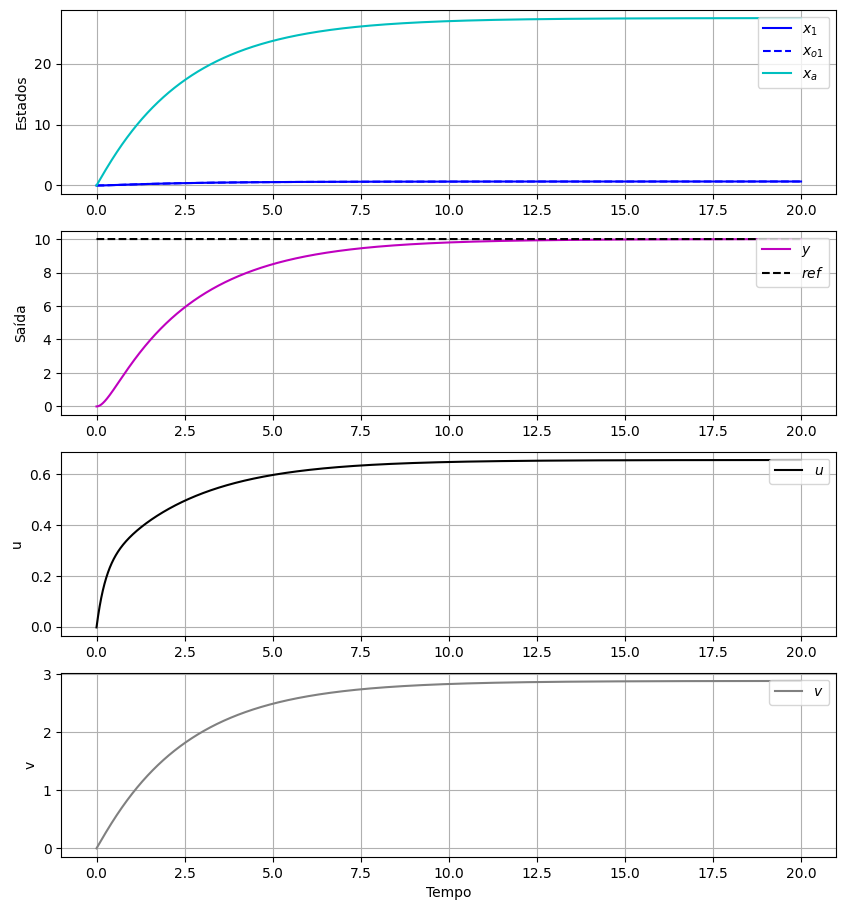

In [80]:
plt.figure(figsize=(10,11))

plt.subplot(4, 1, 1)
plt.plot(time, x1_vec, label='$x_1$', color='blue')
plt.plot(time, xo1_vec, label='$x_{o1}$', color='blue', linestyle='--')
plt.plot(time, xa_vec, label='$x_a$', color='c')
plt.ylabel('Estados')
plt.legend(loc='upper right')
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(time, y_vec, color='m', label='$y$')
plt.plot(time, ref, color='black', label='$ref$', linestyle='--')
plt.ylabel('Saída')
plt.legend(loc='upper right')
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(time, u_vec, color='black', label='$u$')
plt.ylabel('u')
plt.legend(loc='upper right')
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(time, v_vec, color='gray', label='$v$')
plt.xlabel('Tempo')
plt.ylabel('v')
plt.legend(loc='upper right')
plt.grid()